## Title: Housing Prices using Advanced Regression Techniques

The data describes 79 features which can influence the prices of residential homes in Ames, Iowa. We need to predict the final price of each home

Data Source:
Kaggle - https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
Data: Dimensions: 80 columns including dependent variable, rows - 2919 (1459 observations testing and 1460 observations training set). Columns include categorical and continuous variables such as Type of house, Zoning classification of sale, Lot size, type of road access to property, quality of basement, general shape of property, utilities available etc. which shall be refined to identify core features driving property sales


### Importing the libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import RidgeCV
from scipy.stats import norm, skew
import xgboost as xgb
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

C:\Users\vinee\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [9]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [10]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Data cleaning and preprocessing
1. Detecting Outliers
2. Statistical transformation
3. Dealing with missing values

In [11]:
print('Size of training data set:', df_train.shape)
print('Size of testing data set:', df_test.shape)

Size of training data set: (1460, 81)
Size of testing data set: (1459, 80)


In [12]:
id_test = df_test['Id']

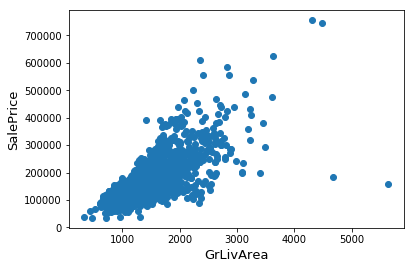

In [13]:
#Outliers
fig, ax = plt.subplots()
ax.scatter(x = df_train['GrLivArea'], y = df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()
#We can see at the right side with extremely large LivArea, Sale Price is low. These are outliers so we delete them

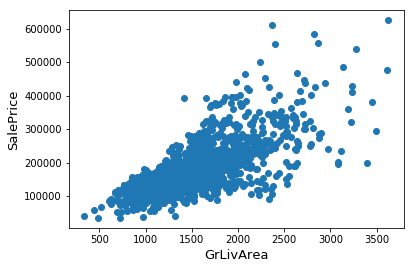

In [14]:
#Deleting outliers
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(df_train['GrLivArea'], df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [15]:
print('Size of training data set:', df_train.shape)
print('Size of testing data set:', df_test.shape)

Size of training data set: (1456, 81)
Size of testing data set: (1459, 80)


In [16]:
#Drop the Id column
df_train.drop("Id", axis = 1 , inplace=True)
df_test.drop("Id", axis = 1 , inplace=True)

We have 79 explanatory variables in the data set with sale price as the dependent variable. Note that id has been removed from the training and testing data set. 

In [17]:
target = 'SalePrice'

### Statistical transformation


The response variable - Sale Price. Lets have a look at how the target variable is distributed

Skewness: 1.565959


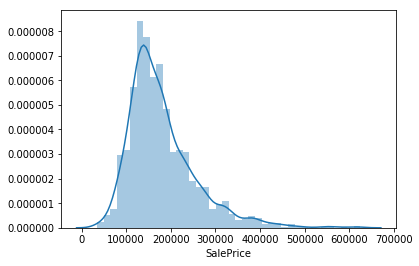

In [18]:
sns.distplot(df_train['SalePrice'] )

print("Skewness: %f" % df_train['SalePrice'].skew())

The target variable is right skewed, it is not normally distributed. This can reduce the performance of linear algorithms as some assume normal distribution. Therefore, we use log transformation

Skewness: 0.065449


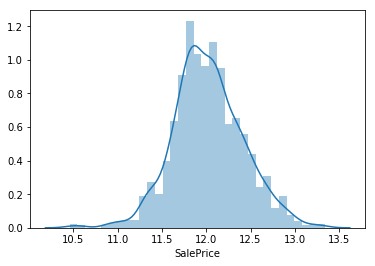

In [19]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])

sns.distplot(df_train['SalePrice'])

print("Skewness: %f" % df_train['SalePrice'].skew())

In [20]:
ntrain = df_train.shape[0]
ntest = df_test.shape[0]

# Also save the target value, as we will remove this
y_train = df_train.SalePrice.values

# concatenate training and test data into data
data = pd.concat((df_train, df_test)).reset_index(drop=True)
data.drop(['SalePrice'], axis=1, inplace=True)

print("Concated Data Shape: {}".format(data.shape))

Concated Data Shape: (2915, 79)


### Missing Values

In [21]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
PoolQC,2907,0.997256
MiscFeature,2810,0.963979
Alley,2717,0.932075
Fence,2345,0.804460
FireplaceQu,1420,0.487136
LotFrontage,486,0.166724
GarageFinish,159,0.054545
GarageQual,159,0.054545
GarageYrBlt,159,0.054545
GarageCond,159,0.054545


Text(0.5,1,'Percent missing data by feature')

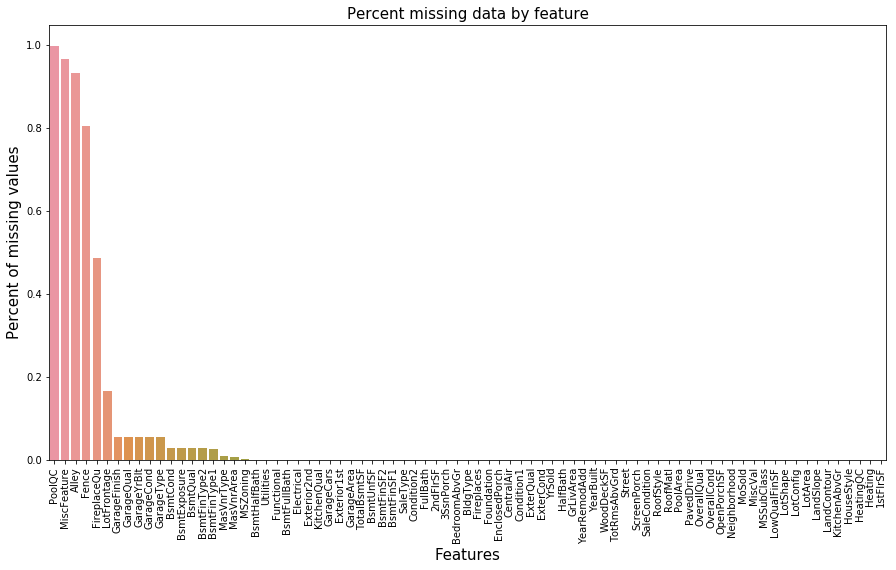

In [22]:
f, ax = plt.subplots(figsize=(15, 8))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data.Percent)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [23]:
#Dropping columns which have more than 80% missing values
for x in ['PoolQC','MiscFeature','Alley','Fence']:
    data = data.drop(x, axis = 1)

For many columns, there are lot of NA values which looks like they have missing values. But they represent that particular feature is absent. Most of the columns can be replaced with None except a few:

1. Functional - document says replace with 'Typ'
2. Electrical, KitchenQual, Exterior1, Exterior2, SaleType - Lets replace with mode as most of the houses would have it

In [25]:
# Fill these features with their mode, the most commonly occuring value. This is okay since there are a low number of missing values for these features
data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].mode()[0])
data['Electrical'] = data['Electrical'].fillna(data['Electrical'].mode()[0])
data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].mode()[0])
data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].mode()[0])
data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0])
data['SaleType'] = data['SaleType'].fillna(data['SaleType'].mode()[0])
data["Functional"] = data["Functional"].fillna(data['Functional'].mode()[0])

In [26]:
cols_fillna = ['MasVnrType','FireplaceQu','GarageQual','GarageCond','GarageFinish','GarageType',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2', 'Utilities','LandSlope']

# replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    data[col].fillna('None',inplace=True)

In [27]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(15)

,Total,Percent
LotFrontage,486,0.166724
GarageYrBlt,159,0.054545
MasVnrArea,23,0.007890
BsmtFullBath,2,0.000686
BsmtHalfBath,2,0.000686
TotalBsmtSF,1,0.000343
GarageCars,1,0.000343
GarageArea,1,0.000343
BsmtFinSF1,1,0.000343
BsmtFinSF2,1,0.000343


In [28]:
# LotArea most likely would be equal to houses in the same neighborhood so replace with the median value after grouping by neighborhood
data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

#Based on data description
for col in ("GarageYrBlt", "GarageArea", "GarageCars", "BsmtFinSF1", 
           "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea",
           "BsmtFullBath", "BsmtHalfBath"):
    data[col] = data[col].fillna(0)

In [29]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
YrSold,0,0.0
Electrical,0,0.0
ExterCond,0,0.0
ExterQual,0,0.0
Exterior1st,0,0.0


As we can see, there are no missing values in our dataset now

### Feature Engineering

1. Factorization
2. Transformation of skewed variables
3. Creating features
4. Dummy values
5. Check correlation and remove less correlated values for numeric columns

#### Factorization

There are features that are read in as numericals but are actually objects. Let's transform them.

In [30]:
factors = ['MSSubClass','OverallCond','OverallQual']

for i in factors:
    data.update(data[i].astype('str'))

In [31]:
numericVars = data.dtypes[data.dtypes != 'object'].index
print("Number of numerical features: ", len(numericVars))
categoricalVars = data.dtypes[data.dtypes == 'object'].index
print("Number of categorical features: ", len(categoricalVars))

Number of numerical features:  33
Number of categorical features:  42


In [32]:
print("Numerical variables" ,data[numericVars].columns)
print("\n")
print("Categorical variables", data[categoricalVars].columns)

Numerical variables Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars',
       'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea',
       'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'MoSold',
       'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF',
       'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold'],
      dtype='object')


Categorical variables Index(['BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical',
       'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'FireplaceQu',
       'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual',
       'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual',
       'LandContour', 'LandSlope', 'LotConf

#### Skewed Variables

In [33]:
# Check the skew of all numerical features
skewed_feats = data[numericVars].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.932147
PoolArea,18.701829
LotArea,13.123758
LowQualFinSF,12.080315
3SsnPorch,11.368094
KitchenAbvGr,4.298845
BsmtFinSF2,4.142863
EnclosedPorch,4.000796
ScreenPorch,3.943508
BsmtHalfBath,3.942892


In [34]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    data[feat] = boxcox1p(data[feat], lam)

There are 33 skewed numerical features to Box Cox transform


#### Relationship between numerical variables and Sale Price

In [35]:
numericVars = numericVars.append(pd.Index(['SalePrice']))

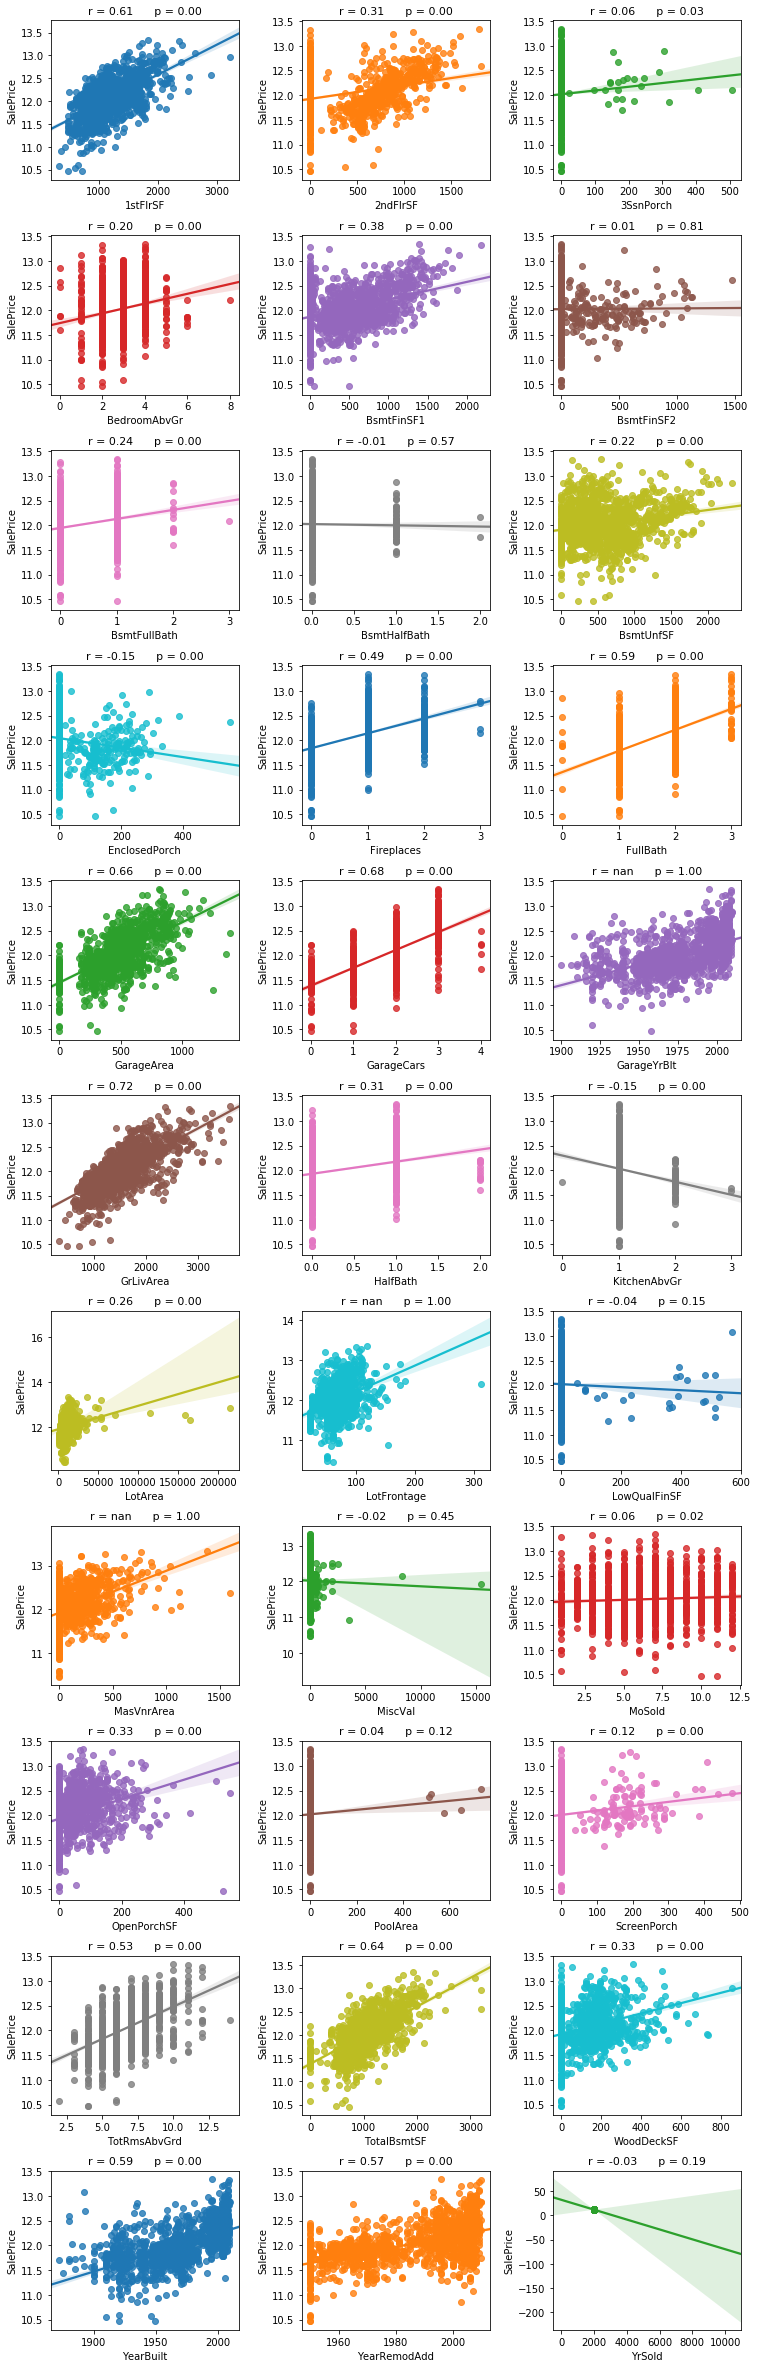

In [36]:
from scipy import stats

nr_rows = 11
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

li_num_feats = list(numericVars)
li_not_plot = ['Id', 'SalePrice']
li_plot_num_feats = [c for c in list(numericVars) if c not in li_not_plot]


for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(df_train[li_plot_num_feats[i]], df_train[target], ax = axs[r][c])
            stp = stats.pearsonr(df_train[li_plot_num_feats[i]], df_train[target])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()   

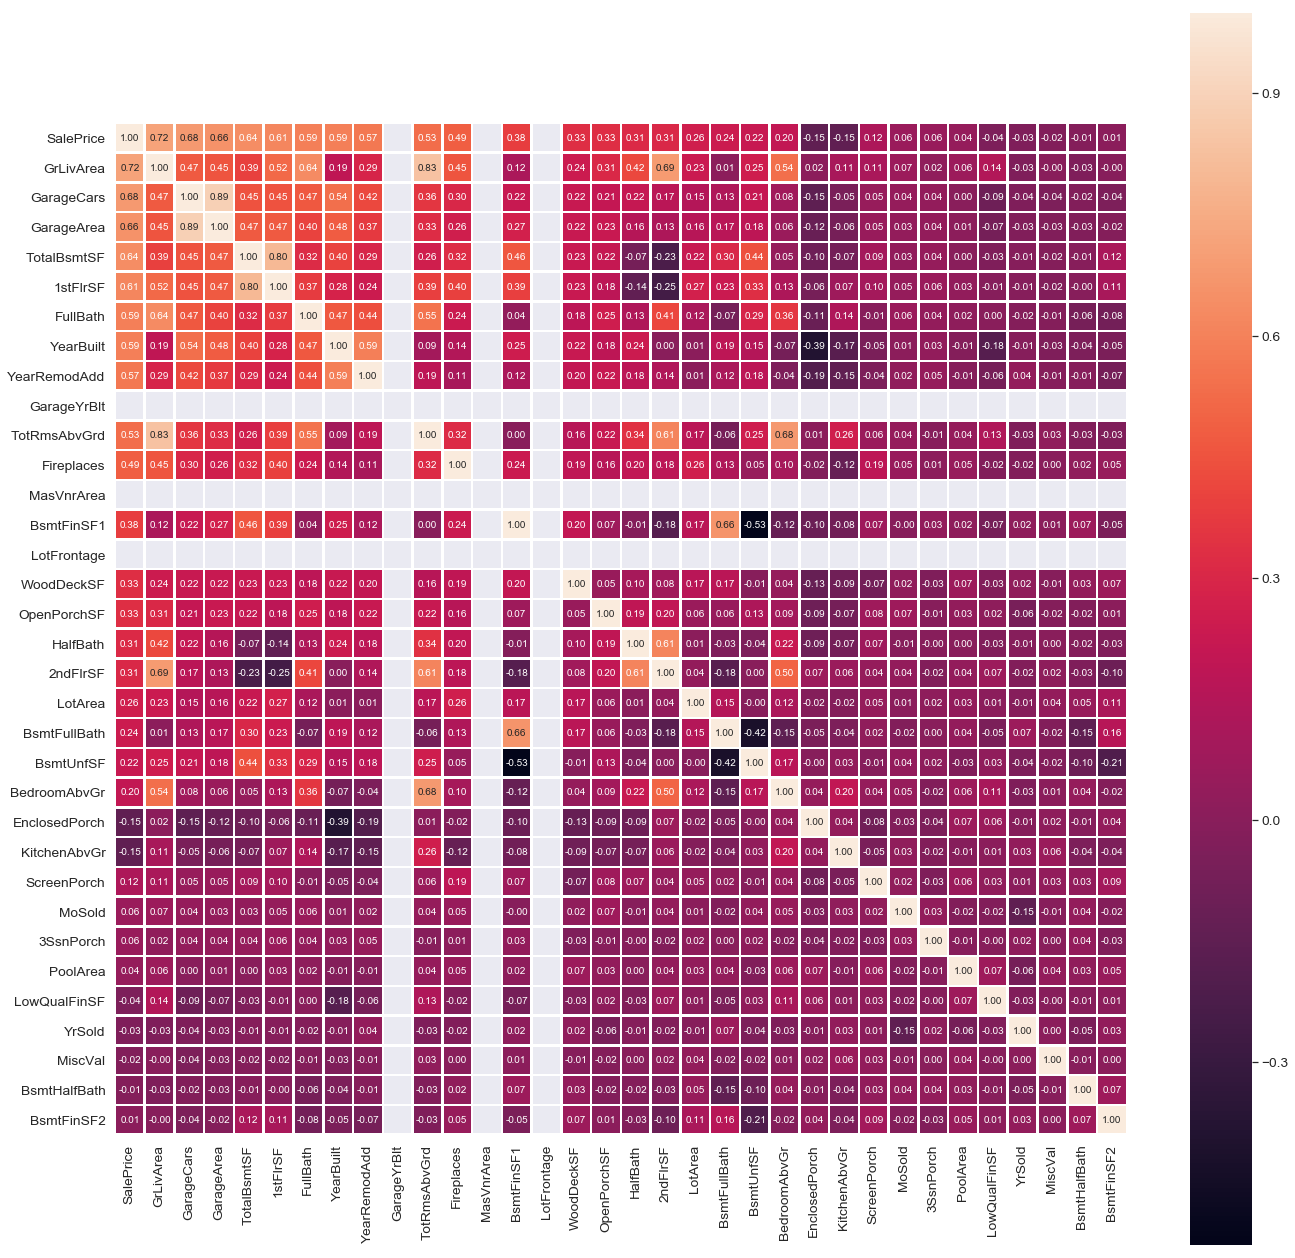

In [37]:
def plot_corr_matrix(df, nr_c, targ) :
    
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    
    cm = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=cols.values, xticklabels=cols.values
               )
    plt.show()
    
plot_corr_matrix(df_train[numericVars], len(numericVars), target)

We can see that Sale Price is highly correlated to some of the variables like Garage Area, Year Built, 1stFlrSF, etc. For some of the features correlation is weak like Enclosed Porch. We, decide to use only those variables which are correlated to Sale Price with a value greater than 0.3.We choose 0.3 as the value as there are some variables with  weak correlation but combination of some might affect the sale price. For example, half bath, full bath combined might have some affect

In [38]:
corr = df_train[numericVars].corr()
corr_abs = corr.abs()

nr_num_cols = len(numericVars)
ser_corr = corr_abs.nlargest(nr_num_cols, target)[target]

cols_abv_corr_limit = list(ser_corr[ser_corr.values > 0.3].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= 0.3].index)

In [39]:
#Numerical variables with correlation value
print("List of numerical features with r above min corr threshold :")
print(cols_abv_corr_limit)
print("List of numerical features with r below min corr threshold :")
print(cols_bel_corr_limit)

List of numerical features with r above min corr threshold :
['SalePrice', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'TotRmsAbvGrd', 'Fireplaces', 'MasVnrArea', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', 'OpenPorchSF', 'HalfBath', '2ndFlrSF']
List of numerical features with r below min corr threshold :
['LotArea', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr', 'EnclosedPorch', 'KitchenAbvGr', 'ScreenPorch', 'MoSold', '3SsnPorch', 'PoolArea', 'LowQualFinSF', 'YrSold', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF2']


In [40]:
data = data.drop(cols_bel_corr_limit, axis=1)

In [41]:
#Lets check levels of variables to check the distribution and if it can be deleted
objects = []
for i in data.columns:
    if data[i].dtype == object:
        objects.append(i)
        
sums_levels = data[objects].apply(lambda x: len(np.unique(x)))
sums_levels.sort_values(ascending=False)

Neighborhood     25
MSSubClass       16
Exterior2nd      16
Exterior1st      15
OverallQual      10
SaleType          9
OverallCond       9
Condition1        9
HouseStyle        8
Condition2        8
GarageType        7
Functional        7
BsmtFinType2      7
BsmtFinType1      7
RoofMatl          7
FireplaceQu       6
Heating           6
GarageQual        6
RoofStyle         6
GarageCond        6
SaleCondition     6
Foundation        6
BsmtQual          5
BsmtExposure      5
Electrical        5
BsmtCond          5
ExterCond         5
BldgType          5
HeatingQC         5
LotConfig         5
MSZoning          5
GarageFinish      4
ExterQual         4
KitchenQual       4
LandContour       4
LotShape          4
MasVnrType        4
LandSlope         3
PavedDrive        3
Utilities         3
Street            2
CentralAir        2
dtype: int64

In [42]:
#lets have a look at some lower numbered variables
print(data['Street'].value_counts())
print('*************')
print(data['Utilities'].value_counts())
print('*************')
print(data['CentralAir'].value_counts())
print('*************')
print(data['PavedDrive'].value_counts())
print("*************")
print(data['LandSlope'].value_counts())

Pave    2903
Grvl      12
Name: Street, dtype: int64
*************
AllPub    2912
None         2
NoSeWa       1
Name: Utilities, dtype: int64
*************
Y    2719
N     196
Name: CentralAir, dtype: int64
*************
Y    2637
N     216
P      62
Name: PavedDrive, dtype: int64
*************
Gtl    2774
Mod     125
Sev      16
Name: LandSlope, dtype: int64


In [43]:
#Lets drop utilities and Street, almost all the values are in one level and it wouldnt make much differnece in our prediction
data = data.drop(['Utilities','Street'], axis = 1)

#### Categorical Variables

In [44]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'LandSlope', 'CentralAir', 'MSSubClass', 'OverallCond')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(data[c].values)) 
    data[c] = lbl.transform(list(data[c].values))

In [45]:
#Dummy encoding
data = pd.get_dummies(data, columns = ["MSZoning"], prefix="MSZoning")
data = pd.get_dummies(data, columns = ["BsmtExposure"], prefix="BsmtExposure")
data = pd.get_dummies(data, columns = ["LotShape"], prefix="LotShape")
data = pd.get_dummies(data, columns = ["LandContour"], prefix="LandContour")
data = pd.get_dummies(data, columns = ["LotConfig"], prefix="LotConfig")
data = pd.get_dummies(data, columns = ["Neighborhood"], prefix="Neighborhood")
data = pd.get_dummies(data, columns = ["PavedDrive"], prefix="PavedDrive")
data = pd.get_dummies(data, columns = ["BldgType"], prefix="BldgType")
data = pd.get_dummies(data, columns = ["RoofStyle"], prefix="RoofStyle")
data = pd.get_dummies(data, columns = ["RoofMatl"], prefix="RoofMatl")
data = pd.get_dummies(data, columns = ["MasVnrType"], prefix="MasVnrType")
data = pd.get_dummies(data, columns = ["ExterCond"], prefix="ExterCond")
data = pd.get_dummies(data, columns = ["Foundation"], prefix="Foundation")
data = pd.get_dummies(data, columns = ["GarageType"], prefix="GarageType")
data = pd.get_dummies(data, columns = ["GarageFinish"], prefix="GarageFinish")
data = pd.get_dummies(data, columns = ["SaleCondition"], prefix="SaleCondition")
data = pd.get_dummies(data, columns=["Heating"], prefix="Heating")
    
#Condition
data['Condition1'] = data['Condition1'].map({"Norm":"Norm", "Feedr":"Street", "PosN":"Pos", "Artery":"Street", "RRAe":"Train","RRNn":"Train", "RRAn":"Train", "PosA":"Pos", "RRNe":"Train"})
data['Condition2'] = data['Condition2'].map({"Norm":"Norm", "Feedr":"Street", "PosN":"Pos", "Artery":"Street", "RRAe":"Train","RRNn":"Train", "RRAn":"Train", "PosA":"Pos", "RRNe":"Train"})

def ConditionMatch(col):
    if col['Condition1'] == col['Condition2']:
        return 0
    else:
        return 1

data['Diff2ndCondition_Flag'] = data.apply(ConditionMatch, axis=1)
data.drop('Condition2', axis=1, inplace=True)
data = pd.get_dummies(data, columns = ["Condition1"], prefix="Condition1")

#HouseStyle
data['HouseStyle'] = data['HouseStyle'].map({"2Story":"2Story", "1Story":"1Story", "1.5Fin":"1.5Story", "1.5Unf":"1.5Story", 
                                                     "SFoyer":"SFoyer", "SLvl":"SLvl", "2.5Unf":"2.5Story", "2.5Fin":"2.5Story"})
data = pd.get_dummies(data, columns = ["HouseStyle"], prefix="HouseStyle")

#Exterior1st and 2nd floor
def Exter2(col):    
    if col['Exterior2nd'] == col['Exterior1st']:
        return 1
    else:
        return 0
    
data['ExteriorMatch_Flag'] = data.apply(Exter2, axis=1)
data.drop('Exterior2nd', axis=1, inplace=True)
data = pd.get_dummies(data, columns = ["Exterior1st"], prefix="Exterior1st")    
data['Electrical'] = data['Electrical'].map({"SBrkr":"SBrkr", "FuseF":"Fuse", "FuseA":"Fuse", "FuseP":"Fuse", "Mix":"Mix"})
data = pd.get_dummies(data, columns = ["Electrical"], prefix="Electrical")    
data['GarageQual'] = data['GarageQual'].map({"None":"None", "Po":"Low", "Fa":"Low", "TA":"TA", "Gd":"High", "Ex":"High"})
data = pd.get_dummies(data, columns = ["GarageQual"], prefix="GarageQual")   
data['SaleType'].map({"WD":"WD", "New":"New", "COD":"COD", "CWD":"CWD", "ConLD":"Oth", "ConLI":"Oth", 
                                           "ConLw":"Oth", "Con":"Oth", "Oth":"Oth"})
data = pd.get_dummies(data, columns = ["SaleType"], prefix="SaleType")

In [46]:
#Data Modeling
# First, re-create the training and test datasets
train = data[:ntrain]
test = data[ntrain:]

print(train.shape)
print(test.shape)

(1456, 179)
(1459, 179)


### Model Building

In [47]:
#Build our cross validation method
kfolds = KFold(n_splits=10, shuffle=True, random_state=23)

#build our model scoring function
def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, train, y_train, 
                                   scoring="neg_mean_squared_error", 
                                   cv = kfolds))
    return(rmse)

In [48]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas = [0.00005, 0.0001, 0.0003, 0.0005, 0.0007, 
          0.0009, 0.01]
alphas2 = [0.00005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
           0.0006, 0.0007, 0.0008]

In [49]:
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [68]:
#Standardize the variables
sc = RobustScaler()
df_ml_sc = sc.fit_transform(data)

train_sc = df_ml_sc[:ntrain]
test_sc = df_ml_sc[ntrain:]

In [71]:
#setup models
ridge = make_pipeline(RobustScaler(), 
                      RidgeCV(alphas = alphas_alt, cv=kfolds))

lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas = alphas2,
                              random_state = 42, cv=kfolds))

elasticnet = make_pipeline(RobustScaler(), 
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas, 
                                        cv=kfolds, l1_ratio=e_l1ratio))

lightgbm = make_pipeline(RobustScaler(),
                        LGBMRegressor(objective='regression',num_leaves=5,
                                      learning_rate=0.05, n_estimators=720))

xgboost = make_pipeline(RobustScaler(),
                        XGBRegressor(learning_rate =0.01, n_estimators=3460, 
                                     max_depth=3))

randomForest = make_pipeline(RobustScaler(), RandomForestRegressor(n_estimators=700, random_state=0))
                            

#prepare dataframes
stackX = np.array(train)
stacky = np.array(y_train)

In [85]:
#scoring 
print("cross validated scores")
from prettytable import PrettyTable
t = PrettyTable(['Model', 'RMSE'])
for model, label in zip([ridge, lasso, elasticnet, xgboost, lightgbm, randomForest],
                     ['Ridge', 'LASSO', 'elasticnet','XGBoost', 'LightGBM','RandomForest']):
    
    SG_scores = cross_val_score(model, stackX, stacky, cv=kfolds,
                               scoring='neg_mean_squared_error')
    t.add_row([label, np.sqrt(-SG_scores.mean())])
    print("RMSE", np.sqrt(-SG_scores.mean()),  label)

cross validated scores
RMSE 0.11509166853766958 Ridge
RMSE 0.1149158994382222 LASSO
RMSE 0.11493878817951085 elasticnet
RMSE 0.1191572569327924 XGBoost
RMSE 0.1219043182769985 LightGBM
RMSE 0.1365814463890393 RandomForest


In [86]:
print(t)

+--------------+---------------------+
|    Model     |         RMSE        |
+--------------+---------------------+
|    Ridge     | 0.11509166853766958 |
|    LASSO     |  0.1149158994382222 |
|  elasticnet  | 0.11493878817951085 |
|   XGBoost    |  0.1191572569327924 |
|   LightGBM   |  0.1219043182769985 |
| RandomForest |  0.1365814463890393 |
+--------------+---------------------+


In [95]:
# RobustScaler
lasso_reg = LassoCV(max_iter=1e7, alphas = alphas2, random_state = 42, cv=kfolds)
lasso_reg.fit(train_sc, y_train)
lasso_var = pd.DataFrame(lasso_reg.coef_, train.columns).sort_values(0, ascending = False)

In [96]:
lasso_var = lasso_var[:30]

Text(0.5,1,'Relative influence')

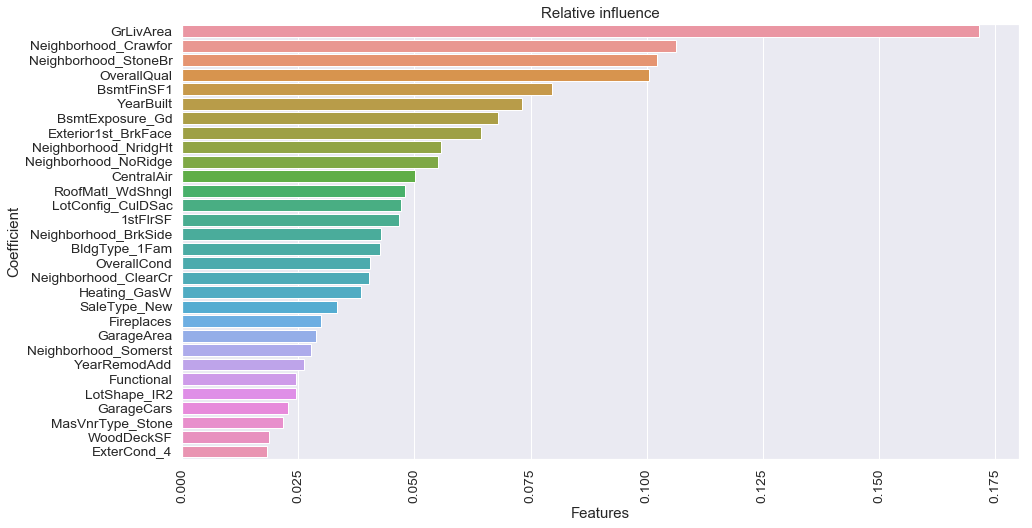

In [97]:
f, ax = plt.subplots(figsize=(15, 8))
plt.xticks(rotation='90')
sns.barplot(y=lasso_var.index, x=lasso_var[0])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Coefficient', fontsize=15)
plt.title('Relative influence', fontsize=15)

In [60]:
#Choose LASSO based on RMSE
lasso_model = lasso.fit(train, y_train)

In [88]:
#Predict using LASSO
lasso_preds = lasso_model.predict(test)

In [59]:
sub = pd.DataFrame()
sub['Id'] = id_test
sub['SalePrice'] = np.expm1(lasso_preds)
sub.to_csv("final_submission.csv", index=False)